# MNIST Classification Task

### Setup

In [3]:
# Utility Functions we'll use later on

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [4]:
# Download MNIST dataset from Scikit-learn
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
# Lets check out the arrays
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

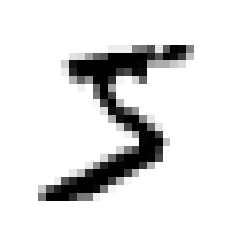

In [7]:
# Lets peek one image
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0] # It is indeed a 5

'5'

In [9]:
# Note the label is a string so we need to cast it to an integer
import numpy as np
y = y.astype(np.uint8)

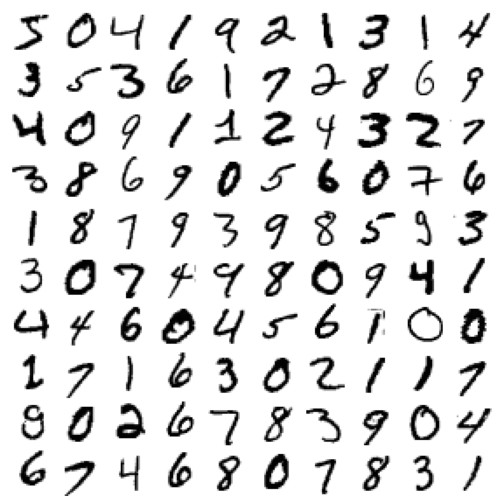

In [10]:
# Let's take one more peek at a couple more values
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [11]:
# Set aside a test set!
# Luckily for us, the dataset is already randomly shuffled and we can just take the first
# 60,000 values for training and the last 10,000 for the test set.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classification

In [10]:
# Lets start with a binary classifier to detect 5 or not 5:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# Now we can use it to make predictions.
sgd_classifier.predict([some_digit])

array([ True])

## Performance Measures
### Measuring Accuracy using Cross-Validation

In [12]:
# In some cases you will need more control and will need to implement Cross-Validation yourself instead of using SciKit
# Below is an example of how to do this (We won't actually be using this, it's just a demo)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

stratified_k_folds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle=True)

for train_index, test_index in stratified_k_folds.split(X_train, y_train_5):
    clone_classifier = clone(sgd_classifier)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_classifier.fit(X_train_folds, y_train_folds)
    y_predictions = clone_classifier.predict(X_test_fold)
    n_correct = sum(y_predictions == y_test_fold)
    print(n_correct / len(y_predictions))

# The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class.
# At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions 
# on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

0.9669
0.91625
0.96785


In [13]:
# Now lets use cross_val_score() to evaluate our SGDClassifier model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# This may look impressive, 93% - 96% accuracy (ratio of correct predictions), but before we get too excited,
# what happens if we just predict 'not-5' on every image and measure the accuracy?

In [15]:
# Lets test the performance on a classifier that always guesses 'NOT 5'
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

We can see that this model has over 90% accuracy!

This demonstrates that accuracy is a bad performance metric for classification models, especially for skewed datasets.

Recall: Skewed datasets happen like this where '5's only make up roughly 10% of the data.

In [16]:
# Instead we need to use a confusion matrix to correctly evaluate the performance of our model (pg. 90)

from sklearn.model_selection import cross_val_predict
# cross_val_predict works like cross_val_score but returns the predictions made on each test fold.

y_train_predictions = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

# Now we are ready to get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predictions)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

We see above our confusion matrix. Each row is an actual class, each column is a predicted class.

The first row is our 'not 5' class, with 53892 correct classifications (true negatives), and 687 wrong classifications (false positives)

The second row is our '5' class, with 1891 wrong classifications as non-5s (false negatives) and 3530 correct classifications as 5s (true positives)

A perfect classifier would have only have true positives and true negatives so it's confusion matrix would have nonzero values only on the main diagonal.

In [17]:
# Now let's calculate the precision and recall of the classifier
from sklearn.metrics import precision_score, recall_score

Precision: The accuracy of the positve predictions is called the precision of the classifier.

precision = TP / (TP + FP)

In [18]:
precision_score(y_train_5, y_train_predictions) # == 3530 / (3530 + 687)

0.8370879772350012

Recall: The senesitivity or the true positive rate (TPR) is the ratio of positive instances that are correctly detected by the classifier

recall = TP / (TP + FN)

In [19]:
recall_score(y_train_5, y_train_predictions) # == 3530 / (3530 + 1891)

0.6511713705958311

It is convenient to combine the precision and recall into a single metric called the F1 score.

The F1 score is the harmonic mean of precision and recall. The classifier will only get a high F1 score if both recall and precision are high.

See pg. 92 for the formula

In [20]:
# Now let's calculate the F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_predictions)

0.7325171197343846

The F1 score favors classifiers that have a similar precision and recall.

The F1 score is a convenient metric to use but not always what you want. 

Depending on your system you may want higher precision with less emphasis on recall or vice versa.

But you can’t always have it both ways - increasing precision reduces recall and vice versa. 

This is called the precision / recall trade off (pg 93/94)

### Precision-Recall Trade off

To understand the trade-off we can look at how the SGD Classifier makes its classification decisions.

For each instance, it computes a score based on a 'decision function'. If that score is greater than its 'decision threshold' it assigns the instane to the positive class; otherwise the negative class.

See pg. 94 for an illustration

In [21]:
# Let's change the 'decision threshold' of our SGD Classifier's decision function and see the effects.
# SKLearn won't let us do this directly, but we can call it's decision_function() instead of predict()
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([ True])

In [23]:
# We can see that with the threshold set to 0 (the default threshold) it correctly classifies the 5

# Now let's increase the threshold
threshold = 8000
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([False])

In [24]:
# And this confirms that increasing the threshold decreases the recall as our '5 classifier' now cannot detect the 5

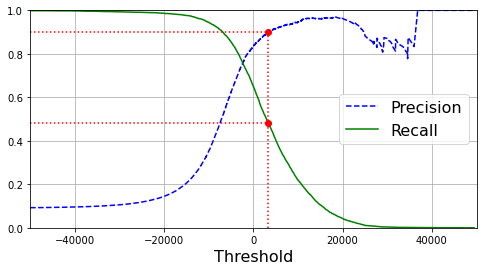

In [25]:
# Let's do the following cross-validation to decide on which threshold value to use
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

Above we can see our plot of precision and recall as functions of the threshold value.

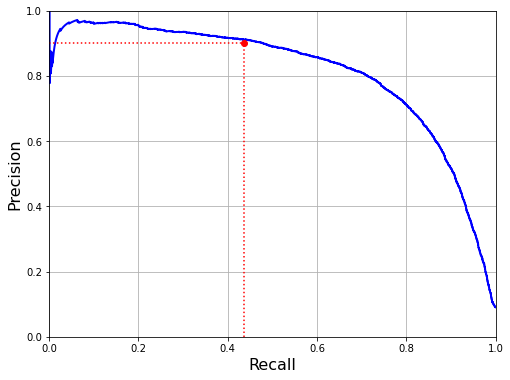

In [26]:
# We can also plot precision vs. recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

Above we have our plot of precision directly against recall.

We can see that precision falls sharpy around 80% recall, so we would probably want to select a precision/recall trade-off before the 80% mark.

Suppose we were aiming for a system with 90% precision, we could see from our first plot we would need a threshold of around 8000. To be more precise we could search for the lowest threshold that gives us at least 90% precision as follows:

In [27]:
# Let's say we want to aim for 90% precision, we use the threshold_90_precision above and run the following:
y_train_predictions_90 = (y_scores >= threshold_90_precision)
# Now let's check what the precision and recall scores are

In [28]:
precision_score(y_train_5, y_train_predictions_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_predictions_90)

0.4799852425751706

In [30]:
# We now have a 90% precision classifier, but with 43% recall. This isn't useful.

### The ROC Curve

The Receiver Operating Characteristic curve is another common tool used with binary classifiers.

It is similar to the precision recall curve but instead plots the true positive rate (recall) against the false positive rate.

The false positive rate (FPR) is the ratio of negative instances that are incorrectly classified as positive.

FPR = 1 - TNR

The true negative rate (TNR) is also called the 'specificity'

Thus, the ROC curve plots sensitivity versus 1-specificity

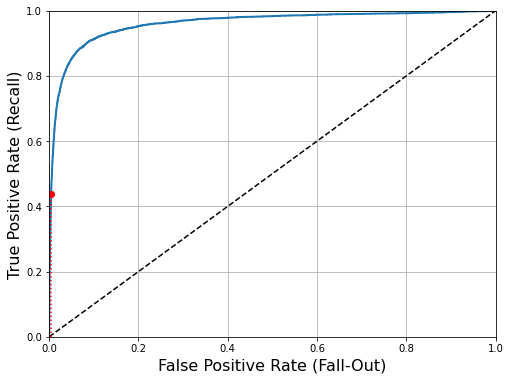

In [31]:
# Next let's plot the ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

As we can see from the graph above there is once again a trade off, the higher the TPR/Recall, the FPR increases too.

Note that the dotted line represents the ROC Curve of a purely random classifier, a good classifier stays away from that line as possible towards the top left corner.

One way to compare classifiers is to measure the area under the curve (AUC). 

A perfect binary classifier would have an ROC AUC of 1, whereas a purely random binary classifier would have an ROC AUC of 0.5

Which metric should you use? The Precision/Recall curve? Or the ROC curve?

As a rule of thumb: (pg. 98)
- Prefer the PR curve when the positive class is rare or when you care more about false positives than false negatives.
- Otherwise, use the ROC Curve.



In [32]:
# Next let's computer the ROC AUC (Area under the Curve)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Next we’ll try a RandomForestClassifier and compare its ROC curve and ROC AUC Score

Note that the RandomForestClassifier doesn't have a decision_function() instead we need to use its predict_proba() function.

Generally SKLearn classifiers have one or the other or both.

In [33]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(random_state=42)
y_probabilities_rfc = cross_val_predict(random_forest_classifier, X_train, y_train_5, cv=3, method="predict_proba")

In [34]:
# The roc_curve() function expects labels and scores but instead of scores we can give it probabilities
y_scores_rfc = y_probabilities_rfc[:,1] # score = proba of positive class
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train_5, y_scores_rfc)

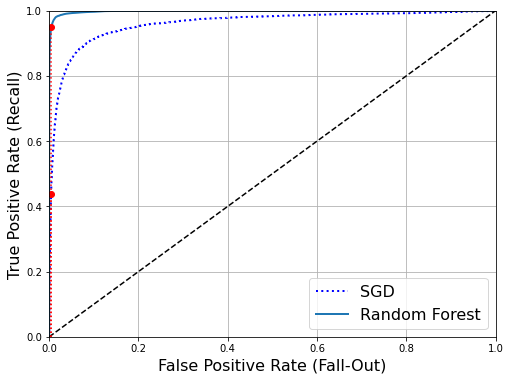

In [35]:
# Now we can plot the ROC Curve for the RF Classifier and compare it to the SGD Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_rfc, tpr_rfc, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [36]:
# From our graph we can see the RandomForestClassifier is superior to the SGDClassifier 
# because the ROC Curve is much closer to the top left corner and has a greater AUC value.
roc_auc_score(y_train_5, y_scores_rfc)

0.9983436731328145

In [37]:
# Let's look at the precision and recall scores of the RandomForestClassifier
y_train_predictions_rfc = cross_val_predict(random_forest_classifier, X_train, y_train_5, cv=3)

In [38]:
# RFC Precision
precision_score(y_train_5, y_train_predictions_rfc)

0.9905083315756169

In [39]:
# RFC Recall
recall_score(y_train_5, y_train_predictions_rfc)

0.8662608374838591

Very good stuff!

# Multiclass Classification

Multiclass Classifiers can distinguish between more than two classes.

Some algorithms can immediately be used as multiclass classifiers, but others only work as binary classifiers, but there are strategies to use multiple binary classifiers together to create a multiclass classifier.

One strategy is to train a classifier to detect numbers 0-9, you could train 10 binary classifiers.
- This is called the one-versus-the-rest / one-versus-all (OvR) strategy.

Another strategy is to train a binary classifier for every pair of digits (ex. 0 or 1, 0 or 2…)
- This is called the one-versus-one (OvO) strategy.
- If there are N classes, you need to train N * (N -1) / 2 classifiers. For the MNIST problem, N = 10, therefore we would need 45 binary classifiers total!

Some algorithms (such as SVM classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train fewer classifiers on larger training sets.

For most binary classification problems OvR is preferred.



In [40]:
# Let's try using a SVM classifier
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train) # Notice we are now training on the full set, not just 5s
svm_classifier.predict([some_digit])

array([5], dtype=uint8)

In [41]:
# Under the hood, SKLearn used the OvO strategy (it trained 45 binary classifiers)

In [42]:
# Here we can see it's returning 10 scores per instance, i.e. one per class
some_digit_scores = svm_classifier.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [43]:
np.argmax(some_digit_scores) # 5 has the highest score

5

In [44]:
svm_classifier.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
# We can force SKLearn to use the OVR or OvO strategy if we want
from sklearn.multiclass import OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(SVC())
ovr_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [46]:
ovr_classifier.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# ^ Predicted a 5

In [47]:
len(ovr_classifier.estimators_) # Notice that here we only have 10 classifiers

10

In [48]:
# Training an SGD Classifier or Random Forest Classifier is just as easy
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
# ^ Predicted a 3

In [49]:
# The decision_function() now returns 1 value per class
sgd_classifier.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Above we can see that the classifier is fairly confident about its predictions. Most scores are largely negative, while 3 has a positive score.

(Note that it predicted wrong in this case, the correct label is 5)

In [50]:
# Next let's evaluate the SGD Classifiers accuracy
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

This accuracy is pretty good, if we were to make a random classifier we would get about 10% accuracy.

In [51]:
# This accuracy is pretty good, but we can do even better if we scale the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

At this point in the project you would now follow the steps in the ML project checklist (Appendix B) to explore data preparation options, try out different models and shortlist the promising ones, and tuning hyperparameters using GridSearchCV, automating as much as possible.

Assuming we have found a promising model, the next step is to find ways to improve it.

Let’s analyze the types of errors it makes.

Let’s start by looking at the confusion matrix.



In [52]:
# First we look at the confusion matrix
y_train_predictions = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv=3)
confusion_matrix = confusion_matrix(y_train, y_train_predictions)

In [53]:
confusion_matrix

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

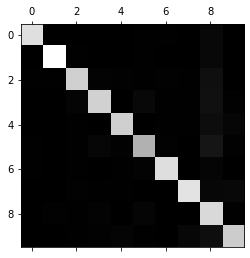

In [54]:
# ^ That's a lot of numbers.
# Let's look at an image representation:
plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()

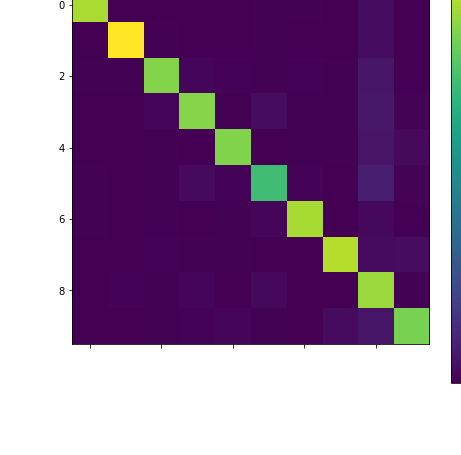

In [55]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(confusion_matrix)

In [56]:
# This looks good, but we need to focus on the errors.
# First we need to divide each value in the matrix by the number of images in
# the corresponding class to compare error rates instead of absolute number of errors.
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_confusion_matrix = confusion_matrix / row_sums

In [57]:
# Let's also fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_confusion_matrix, 0)

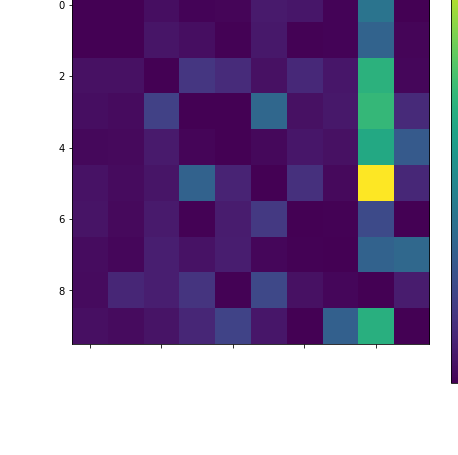

In [58]:
# Now let's take a look at the plot again
plot_confusion_matrix(norm_confusion_matrix)

Here we can clearly see what kinds of errors the classifier makes.

Remember rows represent actual classes, while columns represent predicted classes.



We can see that the most errors come from many images getting incorrectly classified as 8s. The column for 8 shows that many images get classified incorrectly as 8s, however the row for class 8 is not that bad telling us that in general actual 8s do get classified as 8s.

We can also see that 3s and 5s are getting incorrectly classified in both directions.

With these insights, we can look for ways to improve our classifier:

We could put our efforts into reducing the false 8s.
- We could try to gather more training data for digits that look like 8s.
- We could engineer new features to help the classifier Ex. we could create an algorithm to count the number of closed loops (8 has 2, 6 has one, 5 has none)
- We could preprocess the images to make patterns (like loops) stand out more.


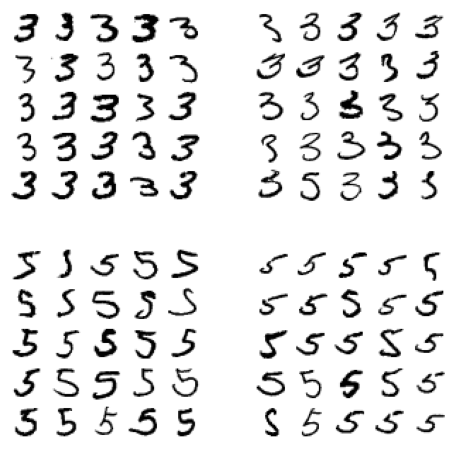

In [59]:
# Let's look at some of the individual errors to gain more insights
class_a, class_b = 3, 5
X_aa = X_train[(y_train == class_a) & (y_train_predictions == class_a)]
X_ab = X_train[(y_train == class_a) & (y_train_predictions == class_b)]
X_ba = X_train[(y_train == class_b) & (y_train_predictions == class_a)]
X_bb = X_train[(y_train == class_b) & (y_train_predictions == class_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The left column shows images that were classified as 3s, the right column shows images that were classified as 5s.
The bottom left and top right are the incorrect classifications.

Some digits are so badly written that even a human would have trouble classifying them, but most misclassified images
are so obviously wrong to us and it's hard to understand why the classifier made those mistakes.

In this case, the reason these errors exist is because the SGD Classifier is a simple linear model, all it does is assign a weight per class to each pixel, and when it sees an image all it does is sum up the weighted
pixel intensities to get a score for each class.

So since 3s and 5s only differ by a few pixels, this model will easily confuse them.

One possible solution to the 3s 5s confusion is to preprocess the images to ensure they are well centered and not too rotated. This will help reduce other errors as well.

# Multilabel Classifcation System

Until now each instance has always been assigned to just one class.

In some cases however, you may want to output multiple classes for each instance.

Such a classification system that outputs multiple binary tags is called a multilabel classification system.

For example, let’s create a system that looks for values larger than 6, and odd values.

In [60]:
# Let's create a system that classifies values >= 7 and odd values
from sklearn.neighbors import KNeighborsClassifier

y_train_large_values = (y_train >= 7)
y_train_odd_values = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large_values, y_train_odd_values]

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_multilabel)
# Note that the knn_classifier supports multilabel classification, but not all classifiers do.

KNeighborsClassifier()

In [61]:
knn_classifier.predict([some_digit])

array([[False,  True]])

In [62]:
# This correctly classified our 5 as 'not large' and 'odd' [False, True    ]

In [63]:
# Next we need to evaluate our multilabel classifier,
# Let's do this by finding the F1 score of each label and taking the average.
y_train_knn_predictions = cross_val_predict(knn_classifier, X_train, y_multilabel, cv=3)

In [64]:
# Taking the average assumes all labels are equally important
f1_score(y_multilabel, y_train_knn_predictions, average="macro")

0.976410265560605

In [65]:
# We can also take a weighted average in the event that not all labels are equal (ex. if there are more than the other)
f1_score(y_multilabel, y_train_knn_predictions, average="weighted")

0.9778357403921755

In [66]:
# Both look pretty good!

# Multioutput Multiclass Classification (Multioutput Classification)

The last type of classification task we are going to discuss is multioutput multiclass classification (multioutput classification)

It is simply a generalization of multilabel classification where each label can be multiclass (more than two possible values)

To demo this we will create a system to remove noise from images.

The input will be a noisy image, and output will be a clean image. (Pixel intensities in, pixel intensities out)

The output will be multilabel (one label per pixel) and each label can have multiple values (in this case a value from 0 to 255)

In [67]:
# Next let's build a multioutput Classification system to remove noise from images
# Let's start by taking the MNIST training and test set and adding noise to the images.
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_noisy = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_noisy = X_test + noise

y_train_clean = X_train
y_test_clean = X_test

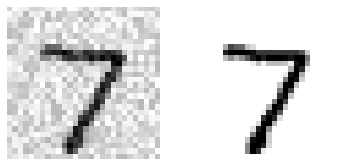

In [68]:
# Next let's be a little naught and look at the test set just to illustrate what we're working with

some_index = 0
plt.subplot(121); plot_digit(X_test_noisy[some_index])
plt.subplot(122); plot_digit(y_test_clean[some_index])
plt.show()

In [69]:
# On the left is our input noisy image
# On the right is our clean unmodified image

In [70]:
# Let's train the classifier and denoise our input image
knn_classifier.fit(X_train_noisy, y_train_clean)

KNeighborsClassifier()

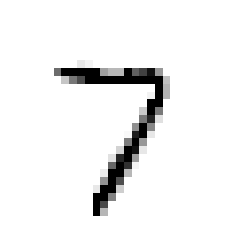

In [71]:
clean_digit = knn_classifier.predict([X_test_noisy[some_index]])
plot_digit(clean_digit)

In [72]:
# Not too bad at all!

# Chapter 3 Exercises

### 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

Hint: KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbor hyperparameters)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameter_grid = [
    {
        'weights': ["uniform", "distance"],
        'n_neighbors': [3,4,5]
    }
]

knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(knn_classifier, parameter_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train) # Train the model

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
# Measure accuracy on the test set
from sklearn.metrics import accuracy_score

y_predictions = grid_search.predict(X_test)
accuracy_score(y_test, y_predictions)

### 2. Write a function that can shift an MNIST image in any direction.

Shift (up, down, left, right) by 1 pixel. Then for each image in the training set, create four shifted copies in each direction and add them to the training set.

Finally, train your best model on this expanded training set and measure it's accuracy on the test set.

This technique of artificially growing the training set is called 'data augmentation' or 'training set expansion'.

In [19]:
from scipy.ndimage.interpolation import shift
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.shift.html

def shift_image(imageArray, dx, dy):
    image = imageArray.reshape((28,28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

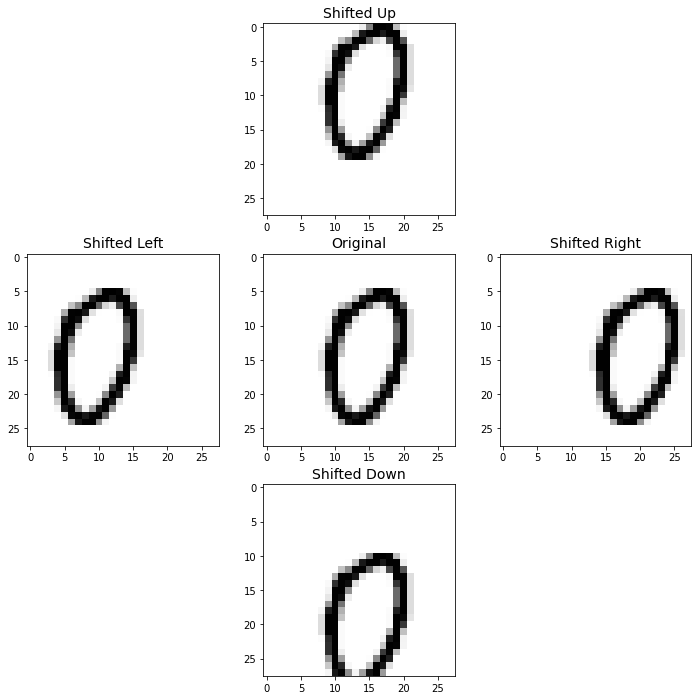

In [20]:
# Let's test this out
some_image = X_train[1000]
some_image_shifted_up = shift_image(some_image, 0, -5)
some_image_shifted_down = shift_image(some_image, 0, 5)
some_image_shifted_left = shift_image(some_image, -5, 0)
some_image_shifted_right = shift_image(some_image, 5, 0)

plt.figure(figsize=(12,12))

plt.subplot(335)
plt.title("Original", fontsize=14)
plt.imshow(some_image.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(332)
plt.title("Shifted Up", fontsize=14)
plt.imshow(some_image_shifted_up.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(338)
plt.title("Shifted Down", fontsize=14)
plt.imshow(some_image_shifted_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(334)
plt.title("Shifted Left", fontsize=14)
plt.imshow(some_image_shifted_left.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(336)
plt.title("Shifted Right", fontsize=14)
plt.imshow(some_image_shifted_right.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.show()

In [22]:
# Now let's creat our expanded / augmented dataset
X_train_expanded = [image for image in X_train]
y_train_expanded = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)): # Left Right Up Down
    for image, label in zip(X_train, y_train):
        X_train_expanded.append(shift_image(image, dx, dy))
        y_train_expanded.append(label)

X_train_expanded = np.array(X_train_expanded)
y_train_expanded = np.array(y_train_expanded)

In [30]:
print(len(X_train_expanded))
print(X_train_expanded.shape)
print(X_train_expanded.size)

300000
(300000, 784)
235200000


In [31]:
# We now need to shuffle our expanded training set
shuffle_index = np.random.permutation(len(X_train_expanded))
X_train_expanded = X_train_expanded[shuffle_index]
y_train_expanded = y_train_expanded[shuffle_index]

In [33]:
from sklearn.neighbors import KNeighborsClassifier
# We can now retrain our best model on the expanded dataset
# knn_classifier = KNeighborsClassifier(**grid_search.best_params)
knn_classifier = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_classifier.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [34]:
# Let's test our model on the test set
y_predictions = knn_classifier.predict(X_test)
accuracy_score(y_test, y_predictions)

### 3. Tackle the Titanic Dataset

I'm going to do Exercises 3 and 4 in a new notebook to keep things organized and manageable.